# XGBoost Regressor Part 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# yahoo_finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AMD'
start = '2014-01-01'
end = '2019-01-01'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.85,3.98,3.84,3.95,3.95,20548400
2014-01-03,3.98,4.00,3.88,4.00,4.00,22887200
2014-01-06,4.01,4.18,3.99,4.13,4.13,42398300
2014-01-07,4.19,4.25,4.11,4.18,4.18,42932100
2014-01-08,4.23,4.26,4.14,4.18,4.18,30678700


In [3]:
# Create more data
dataset['Increase/Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,-1)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,-1)
dataset['Return'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Increase/Decrease,Buy_Sell_on_Open,Buy_Sell,Return
Date,,,,,,,,,,
2014-01-03,3.98,4.00,3.88,4.00,4.00,22887200,1,1,1,0.012658
2014-01-06,4.01,4.18,3.99,4.13,4.13,42398300,1,1,1,0.032500
2014-01-07,4.19,4.25,4.11,4.18,4.18,42932100,0,1,-1,0.012106
2014-01-08,4.23,4.26,4.14,4.18,4.18,30678700,0,-1,-1,0.000000
2014-01-09,4.20,4.23,4.05,4.09,4.09,30667600,0,-1,1,-0.021531


In [4]:
dataset.shape

(1257, 10)

In [5]:
df = dataset.iloc[33:]
df = dataset[:-1]      

df.index = range(len(df))

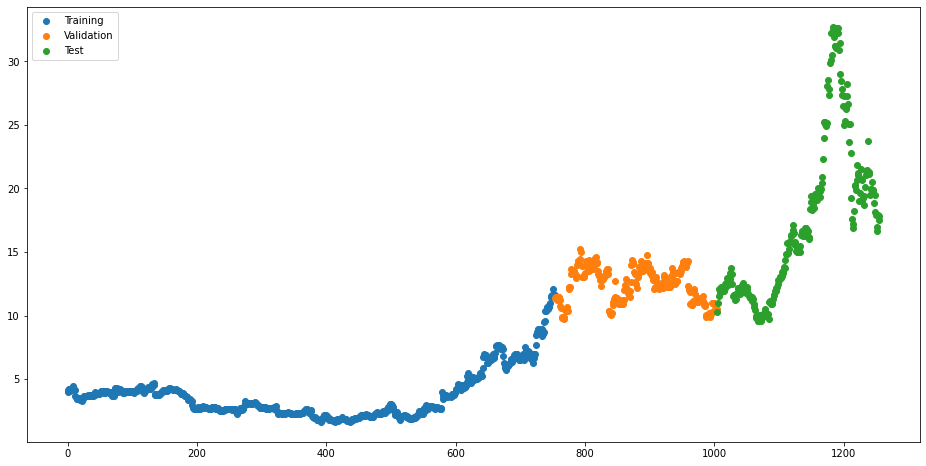

In [6]:
test_size  = 0.20
valid_size = 0.20

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

plt.figure(figsize=(16,8))
plt.scatter(train_df.index, train_df['Adj Close'], label='Training')
plt.scatter(valid_df.index, valid_df['Adj Close'], label='Validation')
plt.scatter(test_df.index,  test_df['Adj Close'],  label='Test')
plt.legend(loc='best')
plt.show()

In [7]:
drop_cols = ['Close', 'Increase/Decrease', 'Buy_Sell_on_Open', 'Buy_Sell']

dataset = dataset.dropna()
train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [8]:
y_train = train_df['Adj Close'].copy()
X_train = train_df.drop(['Adj Close'], 1)

y_valid = valid_df['Adj Close'].copy()
X_valid = valid_df.drop(['Adj Close'], 1)

y_test  = test_df['Adj Close'].copy()
X_test  = test_df.drop(['Adj Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    754 non-null    float64
 1   High    754 non-null    float64
 2   Low     754 non-null    float64
 3   Volume  754 non-null    int64  
 4   Return  754 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 29.6 KB


In [9]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train, verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 400, 'random_state': 42}
Best validation score = -0.022163284567563356
Wall time: 1min 33s


In [10]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

Wall time: 192 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

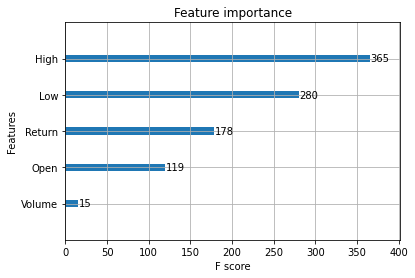

In [11]:
from xgboost import plot_importance

plot_importance(model)



In [12]:
y_pred = model.predict(X_test)
print('y_true = %s' % np.array(y_test)[:5])
print('y_pred = %s' % y_pred[:5])

y_true = [10.27999973 10.97999954 11.55000019 12.11999989 11.88000011]
y_pred = [10.486605 10.667755 11.433056 11.774805 11.841607]


In [13]:
print('mean_squared_error = %s' % mean_squared_error(y_test, y_pred))



mean_squared_error = 67.1401108921124


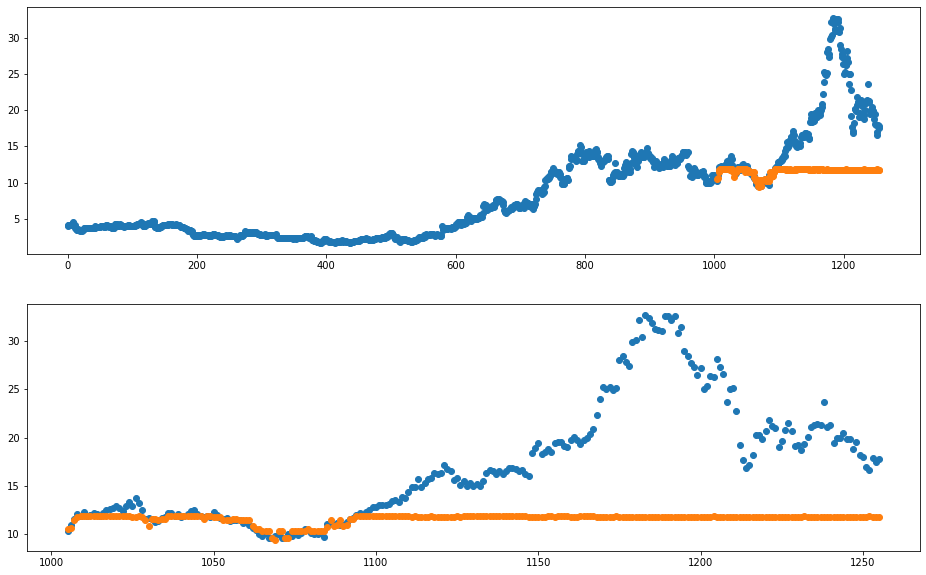

In [14]:
fig, axs = plt.subplots(2)

fig.set_size_inches(16, 10)

predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Adj Close'] = y_pred

axs[0].scatter(df.index, y=df['Adj Close'],
                         label='Truth')

axs[0].scatter(predicted_prices.index, predicted_prices['Adj Close'],
                         label='Prediction')

axs[1].scatter(predicted_prices.index, y_test, label='Truth')

axs[1].scatter(predicted_prices.index, y_pred,label='Prediction')


plt.show()